In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import pandas as pd

%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers.legacy import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.13.0


In [3]:
data_path = "dataset/"
emotions = os.listdir(data_path)
print(emotions)

['.DS_Store', 'nvha', 'lvna', 'hvna', 'neutral', 'lvla', 'lvha']


dataset/.DS_Store
dataset/nvha
dataset/lvna
dataset/hvna
dataset/neutral
dataset/lvla
dataset/lvha


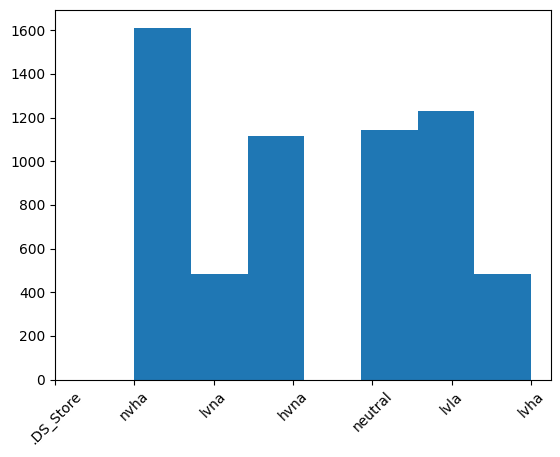

In [4]:
img_size = 48 #By default, the images in FER2013 dataset is in 48x48

data = []
labels = []

# Looping through subfolders in the data path
for emotion in emotions:
    emotion_folder = os.path.join(data_path, emotion)
    print(emotion_folder)
    if not os.path.isdir(emotion_folder):
        continue
    for img in os.listdir(emotion_folder):
        img_path = os.path.join(emotion_folder, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            data.append(img)
            labels.append(emotions.index(emotion))

# Convert image data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Plot the distribution of the labels, bar graph
plt.hist(labels, bins=len(emotions))
plt.xticks(range(len(emotions)), emotions, rotation=45)
plt.show()

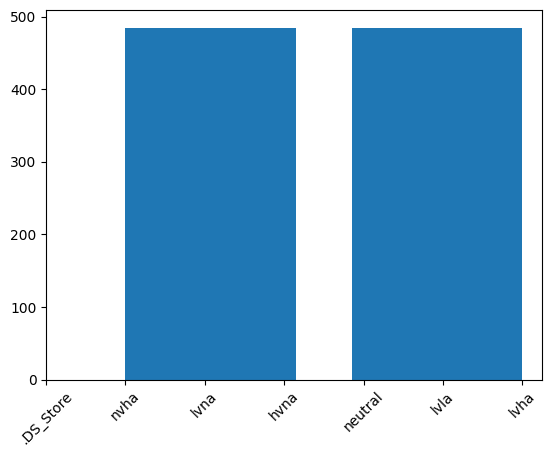

Total data in train set: 2037
Total data in validation set: 873


In [5]:
data_path = "dataset/"
emotions = os.listdir(data_path)

# Find the minimum number of images among all emotions
min_images = float('inf')
for emotion in emotions:
    emotion_folder = os.path.join(data_path, emotion)
    if not os.path.isdir(emotion_folder):
        continue
    num_images = len(os.listdir(emotion_folder))
    if num_images < min_images:
        min_images = num_images

# Randomly select min_images images from each emotion folder
data = []
labels = []
for emotion in emotions:
    emotion_folder = os.path.join(data_path, emotion)
    if not os.path.isdir(emotion_folder):
        continue
    images = os.listdir(emotion_folder)
    selected_images = np.random.choice(images, min_images, replace=False)
    for img in selected_images:
        img_path = os.path.join(emotion_folder, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            data.append(img)
            labels.append(emotions.index(emotion))

# Convert image data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Plot the distribution of the labels, bar graph
plt.hist(labels, bins=len(emotions))
plt.xticks(range(len(emotions)), emotions, rotation=45)
plt.show()

# Split the data into training and validation sets
X_train, X_val, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0

# Reshape the data to add a channel dimension
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_val = X_val.reshape(-1, img_size, img_size, 1)

print("Total data in train set:", len(X_train))
print("Total data in validation set:", len(X_val))

In [6]:
train_dir = "train/"
os.makedirs(train_dir, exist_ok=True)

emotions = [e for e in os.listdir(data_path) if e != 'test']

for emotion in emotions:
    emotion_folder = os.path.join(data_path, emotion)
    if not os.path.isdir(emotion_folder):
        continue
    data = []
    for img in os.listdir(emotion_folder):
        img_path = os.path.join(emotion_folder, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            data.append(img)
    if len(data) == 0:
        continue
    data = np.array(data)
    labels = np.full((len(data),), emotions.index(emotion))
    train_emotion_folder = os.path.join(train_dir, emotion)
    os.makedirs(train_emotion_folder, exist_ok=True)
    for i in range(len(data)):
        img_path = os.path.join(train_emotion_folder, f"{emotion}_{i}.jpg")
        cv2.imwrite(img_path, data[i])
        train_data_count = sum([len(files) for r, d, files in os.walk(train_dir)])

print(f"Total number of data in train folder: {train_data_count}")

Total number of data in train folder: 6071


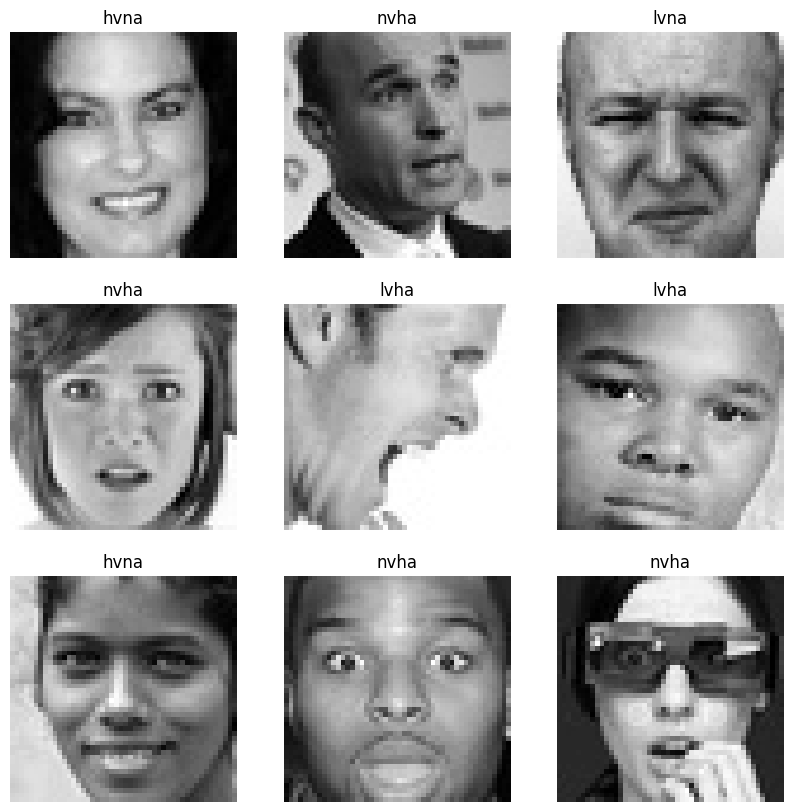

In [7]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i].reshape(img_size, img_size), cmap='gray')
    plt.title(emotions[y_train[i]])
    plt.axis('off')
plt.show()

In [8]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 16
img_size = 48

# Set up data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory(directory="train/",
                                              target_size=(img_size, img_size),
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              subset='training')

test_gen = train_datagen.flow_from_directory(directory="train/",
                                             target_size=(img_size, img_size),
                                             color_mode='grayscale',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             subset='validation')



Found 4859 images belonging to 6 classes.
Found 1212 images belonging to 6 classes.


In [18]:
from keras.layers import ELU
from sklearn.metrics import precision_score, recall_score, f1_score

model = Sequential()

#conv1
model.add(Conv2D(128, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(ELU())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# conv2
model.add(Conv2D(256, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(ELU())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

#conv 3
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(ELU())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

#conv 4
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(ELU())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# flatten layers
model.add(Flatten())

# fully-connected layers
model.add(Dense(256))
model.add(BatchNormalization())
model.add(ELU())
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(ELU())
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

opt = Adam(lr=0.0005)

# compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 
                                                                        tf.keras.metrics.Precision(), 
                                                                        tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 128)       1280      
                                                                 
 batch_normalization_24 (Ba  (None, 48, 48, 128)       512       
 tchNormalization)                                               
                                                                 
 elu_24 (ELU)                (None, 48, 48, 128)       0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 24, 24, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 24, 24, 128)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 256)      

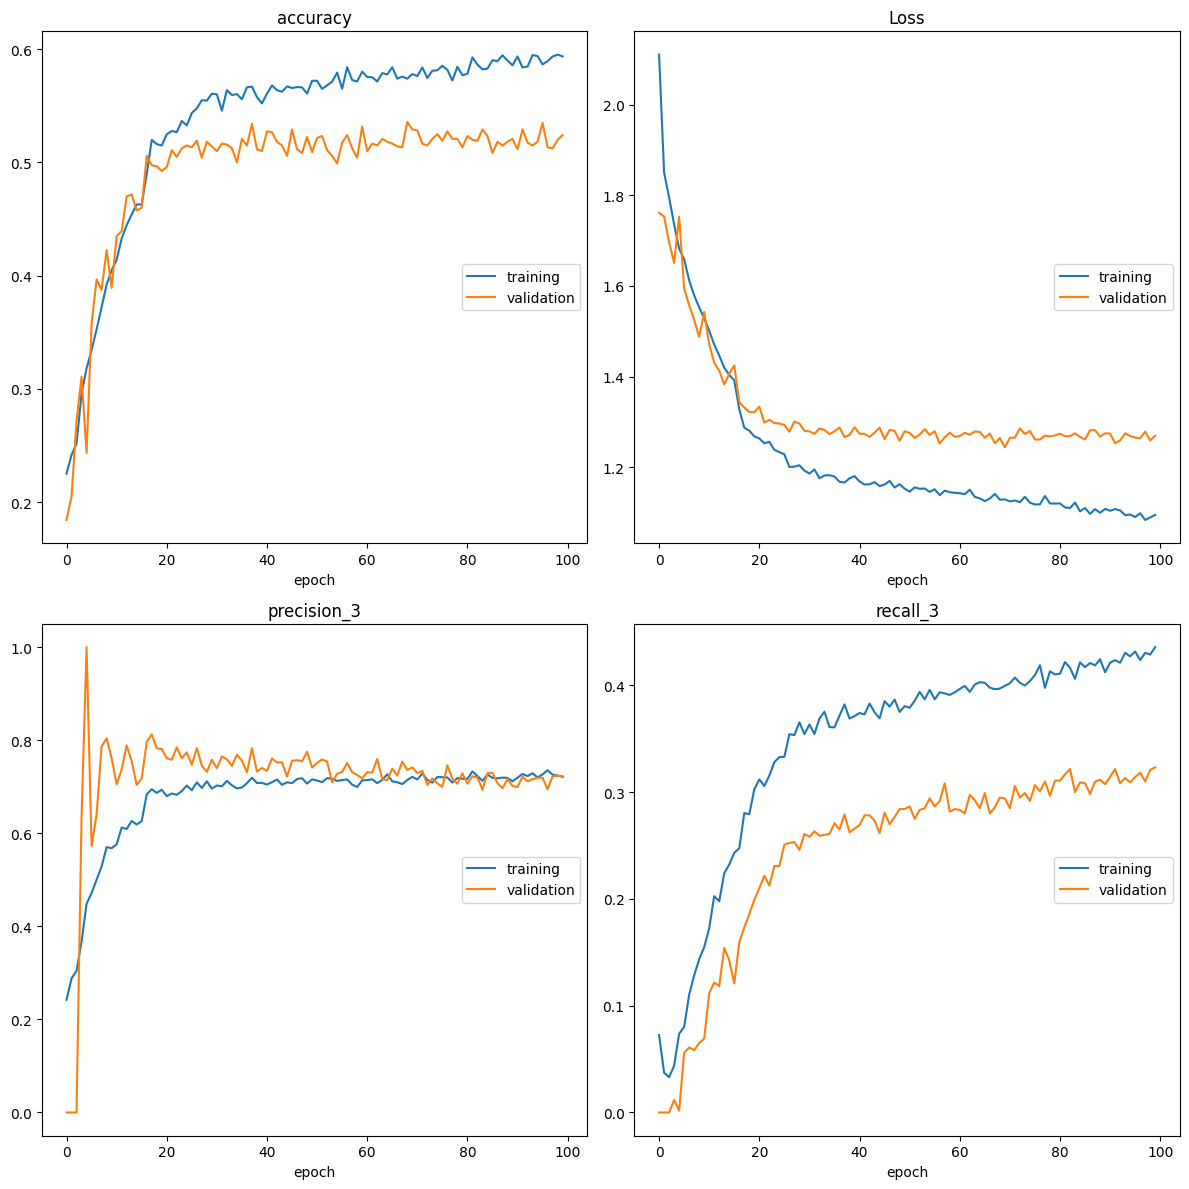

accuracy
	training         	 (min:    0.225, max:    0.595, cur:    0.594)
	validation       	 (min:    0.184, max:    0.536, cur:    0.524)
Loss
	training         	 (min:    1.084, max:    2.110, cur:    1.095)
	validation       	 (min:    1.244, max:    1.761, cur:    1.269)
precision_3
	training         	 (min:    0.242, max:    0.735, cur:    0.721)
	validation       	 (min:    0.000, max:    1.000, cur:    0.723)
recall_3
	training         	 (min:    0.033, max:    0.436, cur:    0.436)
	validation       	 (min:    0.000, max:    0.323, cur:    0.323)

Epoch 100: saving model to model_weights.h5
303/303 [==============================] - 39s 129ms/step - loss: 1.0946 - accuracy: 0.5936 - precision_3: 0.7212 - recall_3: 0.4359 - val_loss: 1.2695 - val_accuracy: 0.5242 - val_precision_3: 0.7225 - val_recall_3: 0.3233 - lr: 1.0000e-05


In [19]:
from keras.callbacks import CSVLogger, TensorBoard

steps_per_epoch = train_gen.n//batch_size
test_steps = test_gen.n//batch_size

epochs = 100

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                            save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, model='auto')
csv_logger = CSVLogger('training.log')
tensorboard = TensorBoard(log_dir='./result', histogram_freq=0, write_graph=True, write_images=False)

callbacks= [PlotLossesKeras(), checkpoint, reduce_lr, csv_logger, tensorboard]

history = model.fit(x = train_gen,
                   steps_per_epoch = steps_per_epoch,
                   epochs=epochs,
                   validation_data=test_gen,
                   validation_steps = test_steps,
                   callbacks=callbacks)


In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)